In [ ]:
import math
class Value:  #creating a object to contain all the neuron related data as a data structure
  
  def __init__(self, data, _children=(), _op='', label=''):  #constructor
    self.data = data  #data
    self.grad = 0.0  #gradient
    self._backward = lambda: None  #backward function intialization
    self._prev = set(_children)  #to keep track of the previous value
    self._op = _op  #to keep track of the operation being performed
    self.label = label  #to input a label for the node
 
  def __repr__(self):   #special function to show the object data in fancy way
    return f"Value(data={self.data})"
  
  def __add__(self, other):   #add functionality
    other = other if isinstance(other, Value) else Value(other)  #if we use a + 1 or 1 + a , it considers the integers as well for addition
    out = Value(self.data + other.data, (self, other), '+')  #base case for addition using the custom made data strcuture Value
    
    def _backward():            #function to perform the backward computation/ gradient calculation for add operation
      self.grad += 1.0 * out.grad  #calculating the gradient for first value object
      other.grad += 1.0 * out.grad  #calculating the gradient for second value object
    out._backward = _backward   #so that we can store the results 
    
    return out

  def __mul__(self, other):   #multiplication functionality
    other = other if isinstance(other, Value) else Value(other)  #so that we can do a *1 or 1 * a
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad  #backward computation/gradient calcuation for multiplication
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):  #power functionality
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():  #backward computation
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other): # other * self  #functionality to do 1 * a 
    return self * other

  def __truediv__(self, other): # self / other  , division functoionality
    return self * other**-1

  def __neg__(self): # -self / negation of the value
    return self * -1

  def __sub__(self, other): # self - other  substraction of the value
    return self + (-other)

  def __radd__(self, other): # other + self  to use the 1 + a fucntionality
    return self + other

  def tanh(self):  #tanh nonlinearity/ activation function
    x = self.data 
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def exp(self):  #exponentiation functionality to calculate the tanh using exp function
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward
    
    return out
  
  
  def backward(self):  #backward computation method that keeps track fo the neurons topologically and computes them sequentially
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [ ]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'

f = Value(-2.0, label = 'f')
L = d * f; 

L.label = 'L'

In [ ]:
L._prev

{Value(data=-2.0), Value(data=4.0)}

In [ ]:
from graphviz import Digraph
#to make the visual graph for the neural networks
def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot



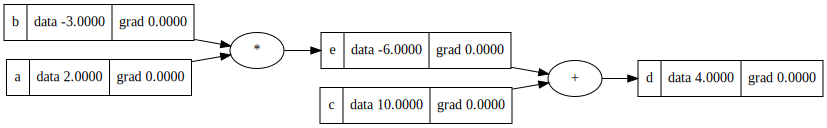

In [ ]:
draw_dot(d)

In [ ]:
a.data += 0.01 + a.grad
b.data += 0.02  + b.grad
c.data += 0.01 + c.grad

e = a+b
d = e+ c
print(d.data) 

9.04


In [ ]:
def lol():
  h = 0.001

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label = 'f')
  L = d * f; L.label = 'L'
  L1 = L.data

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  b.data +=h
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label = 'f')
  L = d * f; L.label = 'L'
  L2 = L.data

  print((L2-L1)/h)
lol()

-3.9999999999995595


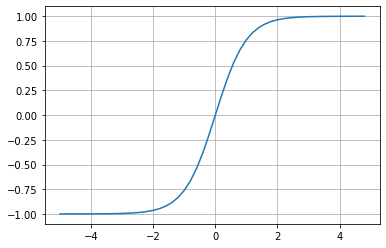

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

In [ ]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
ypred = [n(x) for x in xs]
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b;  n.label = 'n'

o = n.tanh(); o.label = 'o'
o.backward()

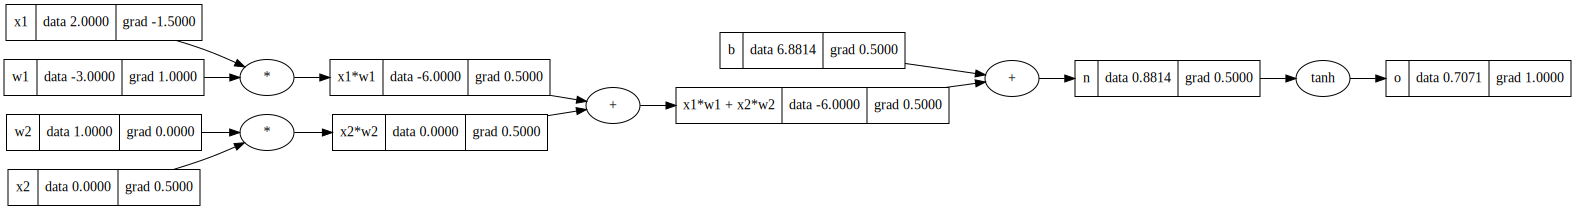

In [ ]:
draw_dot(o)

In [ ]:
#doing all the gradient calculation manually
n.grad = 1 - o.data**2

In [ ]:
o.grad = 1.0

In [ ]:
#tanh(n) = 0
#do/dn - 1 -tanh(n)**2
# do/dn = 1- o**2

#formula for gradient
#dg/dz = dg/dx * dx/dz 

In [ ]:
b.grad = 0.50
x1w1x2w2.grad = 0.5

In [ ]:
x1w1.grad = 0.5
x2w2.grad = 0.5

In [ ]:
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

In [ ]:
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

In [ ]:
#now doing it automatically using the backward function
o.grad = 1.0  # setting the initial grad = -1 so that it does not go to zero

In [ ]:
o._backward()

In [ ]:
n._backward()

In [ ]:
x1w1x2w2._backward()

In [ ]:
x2w2._backward()
x1w1._backward()

In [ ]:
#using topological sort to backprop through the nodes in topological order
topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
build_topo(o)

topo

[Value(data=2.0),
 Value(data=-3.0),
 Value(data=-6.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=0.0),
 Value(data=-6.0),
 Value(data=6.881373587019543),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

In [ ]:
#now calling the backward fuunction to backprop through the nodes
o.backward()

In [ ]:
a =Value(2.0)
d = 1 * a
d

Value(data=2.0)

In [ ]:
#to divide 
a = Value(2.0)
b = Value(4.0)
a / b


Value(data=0.5)

In [ ]:
a - b 

Value(data=-2.0)

In [ ]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b;  n.label = 'n'
# break up the tanh
#o = n.tanh(); 

e = (2*n).exp()  #different way fo calculating tanh
o = (e-1)/(e+1)

o.label = 'o'
o.backward()

In [ ]:
#using the pytorch api to do the same thing
import torch

In [ ]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())


0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [ ]:
import random
class Neuron:  #neuron class to define the base neuron structure

  def __init__(self,nin): #nin is number of inputs
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]  #wieghts intialized with random numbers at the start
    self.b = Value(random.uniform(-1,1)) #bias value computed randomly at the start

  def __call__(self, x):  #call functionality to call the neuron function
    # w*x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)  #doing the calculation w1*x1 + w2 *x2  and starting from the bias value
    out = act.tanh()  #passsing through the tanh nonlinearity
    return out

  def parameters(self):  #parameters fucntion to return the list of wieghts and biases
    return self.w + [self.b]
  
class Layer:  #layer class to define the base layer structure
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]  #looping through the neuron class to make the layers and arrange all the neurons

  def __call__(self, x):
      outs = [n(x) for n in self.neurons]
      return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]  #to return all the wieghts and biases

class MLP:  #MLP class to define the basic structure of the multi-layer perceptron

  def __init__(self, nin, nouts): #nin - number of inputs  nouts - number of outputs
    sz = [nin] + nouts  #the size of the total neurons
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
      for layer in self.layers:  #iterating through the layer class to make multiple layers
        x = layer(x)
      return x 
    
  def parameters(self):
      return [p for layer in self.layers for p in layer.parameters()]

In [ ]:
#neural network intializer
x =[1,2,3]
n = Layer(3,3)
n(x)

[Value(data=0.9998988471232624),
 Value(data=-0.9999999554527839),
 Value(data=0.8724101777447791)]

In [ ]:
#mutli-layer perceptron/ neural network intializer
x = [1,2,4]
n = MLP(3, [3,3,1])
n(x)

Value(data=0.1480847013429397)

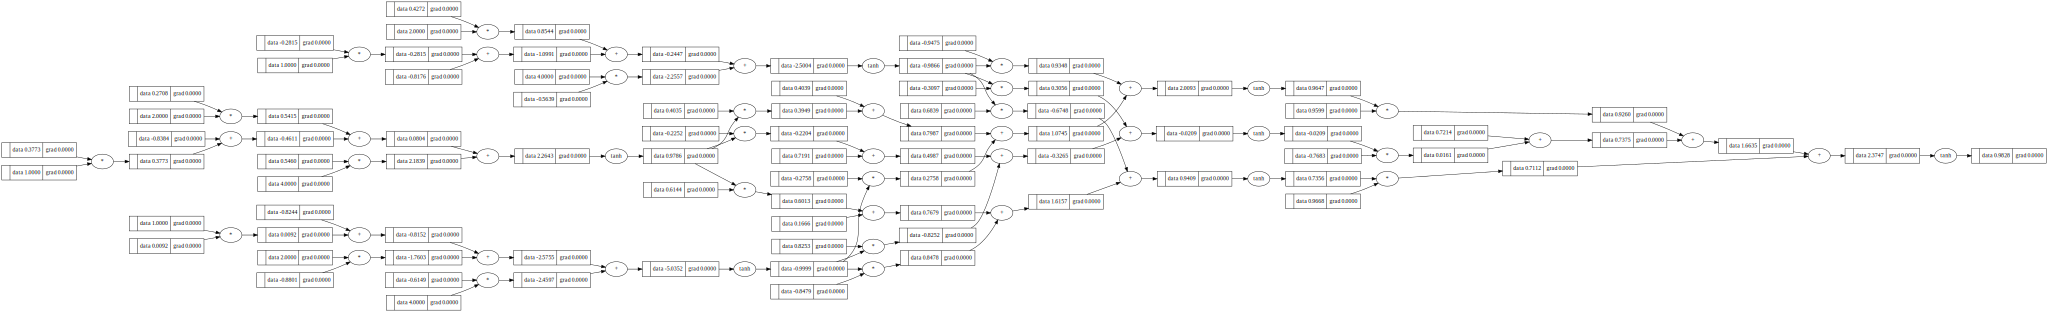

In [ ]:
draw_dot(n(x))

In [ ]:
#test data
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets
ypred = [n(x) for x in xs]
ypred

[Value(data=0.30689506588365606),
 Value(data=0.3133675801297033),
 Value(data=0.04048143006148046),
 Value(data=0.20049348373733777)]

In [ ]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=4.112139142501834)

In [ ]:
loss.backward()

In [ ]:
n.layers[0].neurons[0].w[0].grad

0.0528390384624552

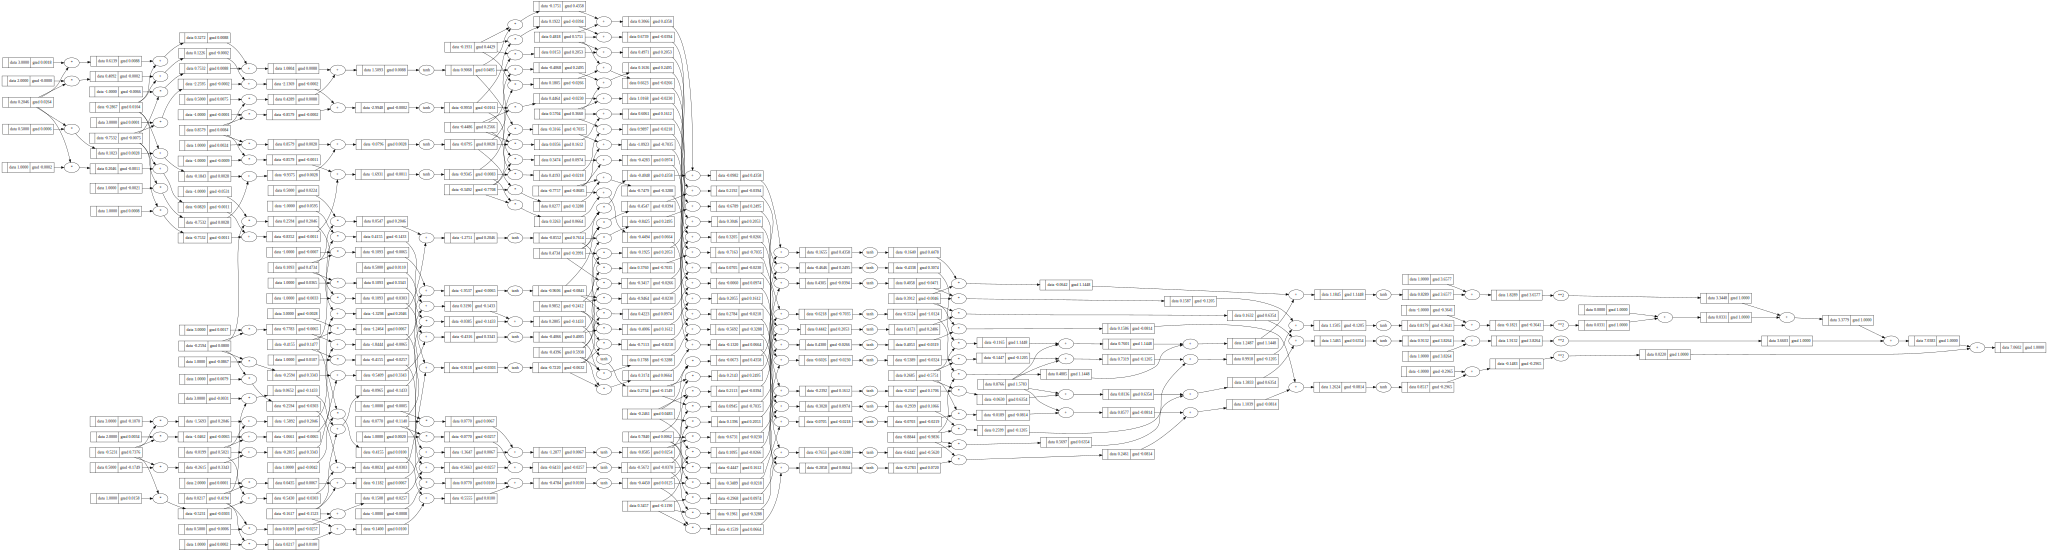

In [ ]:
draw_dot(loss)

In [ ]:
len(n.parameters())

28

In [ ]:
n.layers[0].neurons[0].w[0].data

0.2046191871354961

In [ ]:
n.layers[0].neurons[0].w[0].grad

0.0528390384624552

In [ ]:
for p in n.parameters():
    p.data += -0.01 * p.grad

In [ ]:
ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=1.2082167317739717e-12)

In [ ]:
loss.backward()

In [ ]:
ypred

[Value(data=0.9999999999624306),
 Value(data=-0.9999992227509564),
 Value(data=-0.9999992227608777),
 Value(data=0.9999999999623113)]

In [ ]:
n.parameters()

[Value(data=0.9352053158422543),
 Value(data=3.5178311815909877),
 Value(data=-2.2887254636661845),
 Value(data=2.485602524391116),
 Value(data=1.8012522004289395),
 Value(data=-2.353015120677778),
 Value(data=2.9490578331502872),
 Value(data=1.307754068006034),
 Value(data=-0.32984215984385407),
 Value(data=4.09979574548951),
 Value(data=-5.566247805311024),
 Value(data=-0.4603481456659766),
 Value(data=-0.7057440060660508),
 Value(data=-4.048620294444827),
 Value(data=1.4031219037152962),
 Value(data=-0.6111671626077961),
 Value(data=1.7790572562922877),
 Value(data=4.911946117034106),
 Value(data=-5.483253482412611),
 Value(data=-2.203801592504611),
 Value(data=0.3002724122119842),
 Value(data=4.109113543672204),
 Value(data=-3.2792196034956698),
 Value(data=3.17151565314455),
 Value(data=3.392231924420498),
 Value(data=0.33384293060600523),
 Value(data=-6.809846509307935),
 Value(data=2.4878928619279055)]

In [ ]:
for k in range(20):
  
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  
  # backward pass
  for p in n.parameters():
    p.grad = 0.0 #flushing the grad so that new grad can come for new data
  loss.backward()
  
  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad
  
  print(k, loss.data)
  

0 0.018551816101004467
1 0.017652409373299757
2 0.016836601667425337
3 0.016092843287907624
4 0.015411701202630553
5 0.014785379490178514
6 0.014207367642548898
7 0.013672178008327877
8 0.013175146638246222
9 0.01271228004580333
10 0.012280135765041866
11 0.01187572815646164
12 0.01149645333041906
13 0.01114002872528347
14 0.010804444046802938
15 0.01048792110705368
16 0.010188880701533688
17 0.009905915101539322
18 0.00963776506327687
19 0.009383300497645488


In [ ]:
ypred

[Value(data=0.9570972318044514),
 Value(data=-0.9461944508096922),
 Value(data=-0.9554206819378066),
 Value(data=0.9484219013897984)]

**Defining the proper structure of neural network from scratch**


In [ ]:
#defining the data structure
import math
class Value:  #creating a object to contain all the neuron related data as a data structure
  
  def __init__(self, data, _children=(), _op='', label=''):  #constructor
    self.data = data  #data
    self.grad = 0.0  #gradient
    self._backward = lambda: None  #backward function intialization
    self._prev = set(_children)  #to keep track of the previous value
    self._op = _op  #to keep track of the operation being performed
    self.label = label  #to input a label for the node
 
  def __repr__(self):   #special function to show the object data in fancy way
    return f"Value(data={self.data})"
  
  def __add__(self, other):   #add functionality
    other = other if isinstance(other, Value) else Value(other)  #if we use a + 1 or 1 + a , it considers the integers as well for addition
    out = Value(self.data + other.data, (self, other), '+')  #base case for addition using the custom made data strcuture Value
    
    def _backward():            #function to perform the backward computation/ gradient calculation for add operation
      self.grad += 1.0 * out.grad  #calculating the gradient for first value object
      other.grad += 1.0 * out.grad  #calculating the gradient for second value object
    out._backward = _backward   #so that we can store the results 
    
    return out

  def __mul__(self, other):   #multiplication functionality
    other = other if isinstance(other, Value) else Value(other)  #so that we can do a *1 or 1 * a
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad  #backward computation/gradient calcuation for multiplication
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):  #power functionality
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():  #backward computation
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other): # other * self  #functionality to do 1 * a 
    return self * other

  def __truediv__(self, other): # self / other  , division functoionality
    return self * other**-1

  def __neg__(self): # -self / negation of the value
    return self * -1

  def __sub__(self, other): # self - other  substraction of the value
    return self + (-other)

  def __radd__(self, other): # other + self  to use the 1 + a fucntionality
    return self + other
  
  def __rtruediv__(self, other): # other / self
        return other * self**-1
        
  def __rsub__(self, other): # other - self
        return other + (-self)

  def tanh(self):  #tanh nonlinearity/ activation function
    x = self.data 
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def exp(self):  #exponentiation functionality to calculate the tanh using exp function
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad 
    out._backward = _backward
    
    return out
  
  def relu(self):  #relu nolinearity 
    out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

    def _backward():
      self.grad += (out.data > 0) * out.grad
    out._backward = _backward
  
  
  def backward(self):  #backward computation method that keeps track fo the neurons topologically and computes them sequentially
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [ ]:
#to visualize the neural network
from graphviz import Digraph
#to make the visual graph for the neural networks
def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot


In [ ]:
#defining the neuron, layer and MLP class 

import random
class Neuron:  #neuron class to define the base neuron structure

  def __init__(self,nin): #nin is number of inputs
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]  #wieghts intialized with random numbers at the start
    self.b = Value(random.uniform(-1,1)) #bias value computed randomly at the start

  def __call__(self, x):  #call functionality to call the neuron function
    # w*x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)  #doing the calculation w1*x1 + w2 *x2  and starting from the bias value
    out = act.tanh()  #passsing through the tanh nonlinearity
    return out

  def parameters(self):  #parameters fucntion to return the list of wieghts and biases
    return self.w + [self.b]
  
class Layer:  #layer class to define the base layer structure
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]  #looping through the neuron class to make the layers and arrange all the neurons

  def __call__(self, x):
      outs = [n(x) for n in self.neurons]
      return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]  #to return all the wieghts and biases

class MLP:  #MLP class to define the basic structure of the multi-layer perceptron

  def __init__(self, nin, nouts): #nin - number of inputs  nouts - number of outputs
    sz = [nin] + nouts  #the size of the total neurons
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
      for layer in self.layers:  #iterating through the layer class to make multiple layers
        x = layer(x)
      return x 
    
  def parameters(self):
      return [p for layer in self.layers for p in layer.parameters()]

In [ ]:
#manual inputs provided by the user

#inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
ypred = [n(x) for x in xs]
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b;  n.label = 'n'

o = n.tanh(); o.label = 'o'
o.backward()

In [ ]:
#mutli-layer perceptron/ neural network intializer while using the test data
x = [1,2,4]
n = MLP(3, [3,3,1])
n(x)

Value(data=0.5877244711998213)

In [ ]:
#test data
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets
ypred = [n(x) for x in xs]
ypred

[Value(data=0.5573865147016754),
 Value(data=-0.7371910109398185),
 Value(data=0.6321213604548919),
 Value(data=0.4870724766869131)]

In [ ]:
#doing the training of neural network with forward and backward propagation
for k in range(20):
  
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  
  # backward pass
  for p in n.parameters():
    p.grad = 0.0 #flushing the grad so that new grad can come for new data
  loss.backward()
  
  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad
  
  print(k, loss.data)
  

0 3.191890041523989
1 2.733584148056508
2 2.285055608319963
3 1.6493201189451725
4 0.7875770069389723
5 0.2987269798748227
6 0.15962028208349358
7 0.10579227186237443
8 0.07889347619079581
9 0.0625066174686276
10 0.051546593716530205
11 0.04373283097917127
12 0.03789755012388499
13 0.033383485530311056
14 0.02979351257576538
15 0.026874062398411773
16 0.024455904715015332
17 0.02242192659938827
18 0.02068859205703678
19 0.019194767369137725


In [ ]:
ypred

[Value(data=0.9229911187125904),
 Value(data=-0.9861364272040086),
 Value(data=-0.9226156714526965),
 Value(data=0.9158342907318389)]

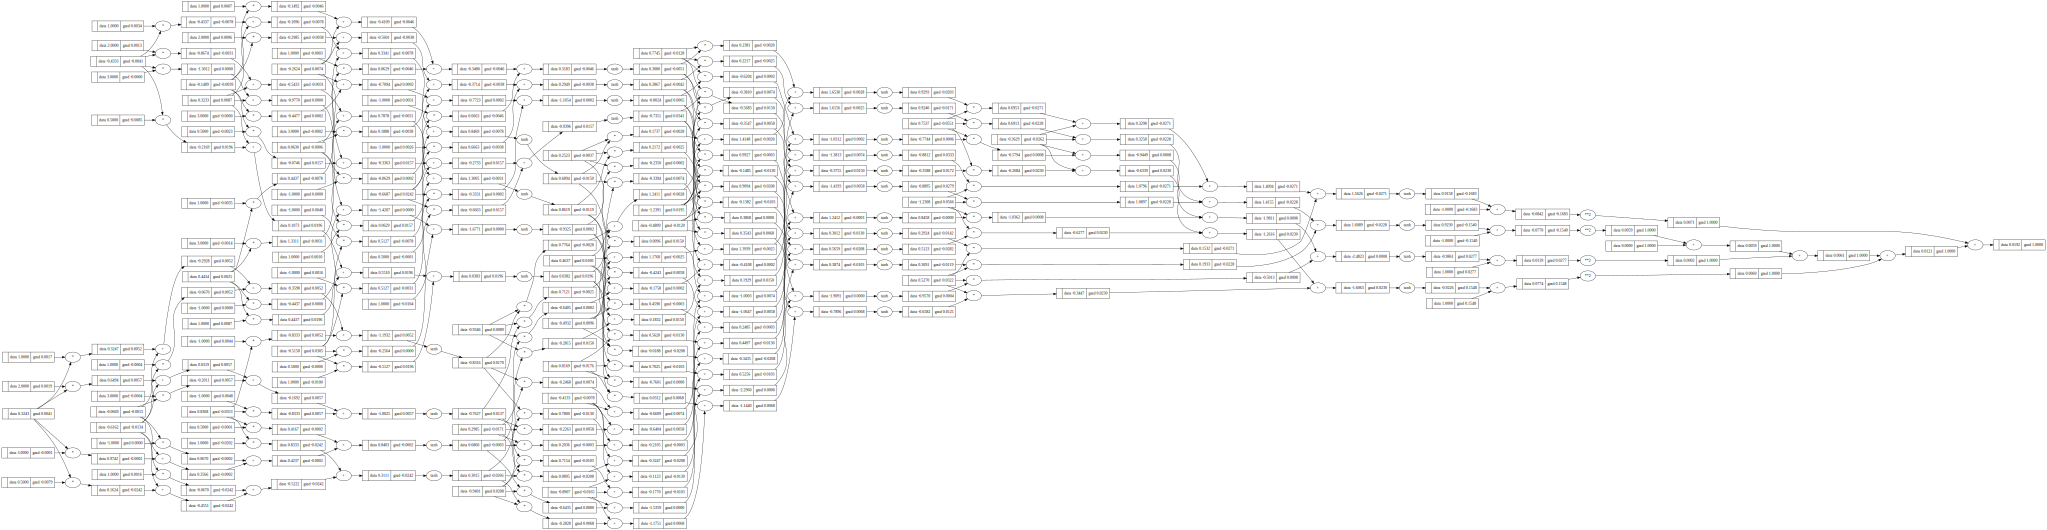

In [ ]:
#drawing the neural network after forward and backward propagation
draw_dot(loss)